In [1]:
!ls

'Arima Model.ipynb'
 daily-min-temperatures.csv
'LSTM Model.ipynb'
 shampoo.csv
'Simple Approach.ipynb'
 steps_stationarity.txt
 steps_test.txt
 steps_train.txt
 TimeSeries.ipynb
'TimeSeries-with all manifold learning methods from scikit learn.ipynb'
'TimeSeries-with PCA.ipynb'
'Vector AutoRegression.ipynb'
'Vector AutoRegression (VAR).ipynb'


In [39]:
import pandas as pd
import numpy as np
from functools import partial
from collections import OrderedDict
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import hankel, eigh
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
n_neighbors = 10
n_components = 1
# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

In [4]:
methods.keys()

odict_keys(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE', 'Isomap', 'MDS', 'SE', 't-SNE'])

In [56]:
df = pd.read_csv('steps_train.txt', skiprows=1,nrows=110, header=None, usecols=[1,2])
df_test = pd.read_csv('steps_test.txt', skiprows=1, nrows=150, header=None, usecols=[1,2])

### Locally Linear Embedding
Locally linear embedding (LLE) seeks a lower-dimensional projection of the data which preserves distances within local neighborhoods. It can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.

In [5]:
method = methods['LLE']

In [8]:
X_train_data = method.fit_transform(df)

In [9]:
N = len(X_train_data)
L = (N)//2
# trajectory_matrix = hankel(series[:L], hankel(series[L-1:]))
# d2 = hankel(df[2][:L], hankel(df[2][L-1:]))

In [10]:
X_train = hankel(X_train_data[:L],X_train_data[L-1:]) # Creating trajectory matrix

In [11]:
X_train.shape

(55, 56)

Text(0.5, 0, 'Cardinal Number of Eigen value ->')

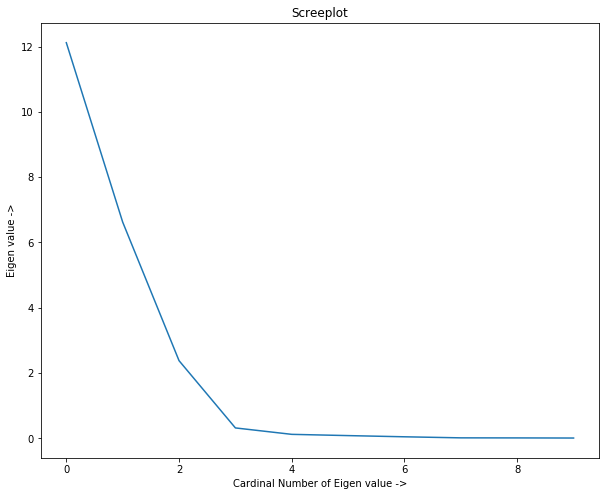

In [12]:
eigenValues, eigenVectors = eigh(np.matmul(X_train, X_train.T))
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
# Sree plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(eigenValues[0:10])
ax.set_title("Screeplot")
ax.set_ylabel("Eigen value ->")
ax.set_xlabel("Cardinal Number of Eigen value ->")

In [27]:
# From the above scree plot, it is seen that the first eigen value is more 
# significant and the other eigen values are close to zero. Thus we choose r as 1
# and then we compute the U for projection and centroid in the signal subspace
r = 1
# Extracted Training signals
U, Sigma, V = np.linalg.svd(X_train)
V = V.T
# d = np.linalg.matrix_rank(X_train)
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,r)] )
X_train_extracted = X_elem.sum(axis=0)
X_train_extracted_data = np.asarray(list(X_train_extracted[:,0]) + list(X_train_extracted[:,-1]))

U = eigenVectors[:,:r] # r as statistical dimension
UT = U.T
pX = np.matmul(UT,X_train_extracted)
centroid = np.mean(pX, axis=1)
centroid = centroid[:,np.newaxis]

In [29]:
# Calculating the departure threshold in signal subspace using centroid and UT

# #For training phase
# Xtrg = hankel(X_train_data[:L], X_train_data[L-1:])
# pXtrg = np.matmul(UT,Xtrg)
# dtrg_matrix = centroid - pXtrg
# dtrg_scores = np.linalg.norm(dtrg_matrix, axis=0, ord=2)

# For Validation phase and threshold calculation
# Xt = hankel(X_train_data[:L],X_train_data[L-1:])
pXt = np.matmul(UT,X_train)
dt_matrix = centroid - pXt
dt_scores = np.linalg.norm(dt_matrix, axis=0, ord=2)
# d_scores = np.asarray([np.matmul(d_matrix[:,i].T, d_matrix[:,i]) for i in range(d_matrix.shape[1])])
np.max(dt_scores)


0.7258421068234178

In [35]:
# Testing positional Deviation
X_test = method.fit_transform(df_test)
Xj = hankel(X_test[:L],X_test[L-1:])
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
# dj_scores = [np.matmul(dj_matrix[:,i].T, dj_matrix[:,i]) for i in range(dj_matrix.shape[1])]
dj_scores = np.asarray(dj_scores)
np.max(dj_scores)

0.3973796898518659

In [55]:
fig = make_subplots(rows=2, cols=2,specs=[[{}, {}], [{"colspan": 2}, None]],
    subplot_titles=("Training plot","Testing plot", "Anomaly scoring by (Locally Linear Embedding)"))
fig.add_trace(go.Scatter(x=df[1], y=df[2], marker_color='blue',
                        name="Training path"),row=1, col=1)
fig.add_trace(go.Scatter(x=df_test[1], y=df_test[2], marker_color='red',
                        name="Testing Score"),row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(len(dt_scores))), y=dt_scores, marker_color='blue',
                         name="Training Score"), row=2, col=1)
fig.add_trace(go.Scatter(x=list(range(len(dj_scores))), y=dj_scores, marker_color='red',
                        name="Testing Score"), row=2, col=1)
fig.update_layout(showlegend=False)
